

## Pipeline

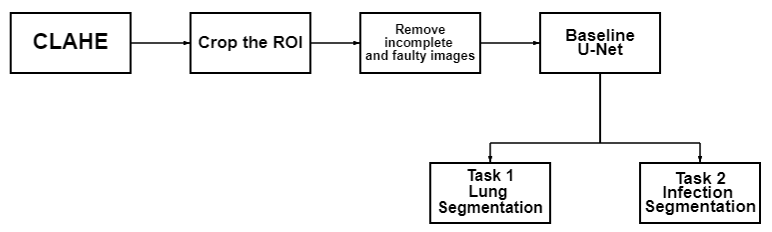

#  **Importing Libraries**

In [1]:
# Loading dependencies

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pandas as pd
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import cv2
import copy
import catalyst
import wandb

from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, Dropout2d, UpsamplingNearest2d
from albumentations import Compose,HorizontalFlip,VerticalFlip, Rotate
from albumentations.pytorch import ToTensor
from tqdm.autonotebook import tqdm, trange
from catalyst import dl
from catalyst.contrib.nn import DiceLoss, IoULoss, FocalLossBinary
from catalyst.dl.runner import SupervisedRunner
from torch.nn.functional import interpolate

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
seed = 271
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
wandb.login()

wandb: ERROR Not authenticated.  Copy a key from https://app.wandb.ai/authorize


API Key:  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
#20 CT-scans + (lung masks / infection masks / lungs + infections mask)

metadata = pd.read_csv('/kaggle/input/covid19-ct-scans/metadata.csv')
print(metadata.shape)
metadata.head()

(3, 4)


,ct_scan,lung_mask,infection_mask,lung_and_infection_mask
0,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
1,../input/covid19-ct-scans/ct_scans/radiopaedia...,../input/covid19-ct-scans/lung_mask/radiopaedi...,../input/covid19-ct-scans/infection_mask/radio...,../input/covid19-ct-scans/lung_and_infection_m...
2,../input/covid19-ct-scans/lung_mask/radiopaedi...,../input/covid19-ct-scans/infection_mask/radio...,../input/covid19-ct-scans/lung_and_infection_m...,NaN


## **CLAHE Enhancer**

In [5]:
def clahe_enhancer(img, clahe, axes):
    '''Contract Limited Adaptive Histogram Equalizer'''
    img = np.uint8(img*255)  
    clahe_img = clahe.apply(img)

    if len(axes) > 0 :    
        axes[0].imshow(img, cmap='bone')
        axes[0].set_title("Original CT scan")
        axes[0].set_xticks([]); axes[0].set_yticks([])

        axes[1].imshow(clahe_img, cmap='bone')
        axes[1].set_title("CLAHE Enhanced CT scan")
        axes[1].set_xticks([]); axes[1].set_yticks([])

        if len(axes) > 2 :
            axes[2].hist(img.flatten(), alpha=0.4, label='Original CT scan')
            axes[2].hist(clahe_img.flatten(), alpha=0.4, label="CLAHE Enhanced CT scan")
            plt.legend()
        
    return(clahe_img)

Number of slices:  301


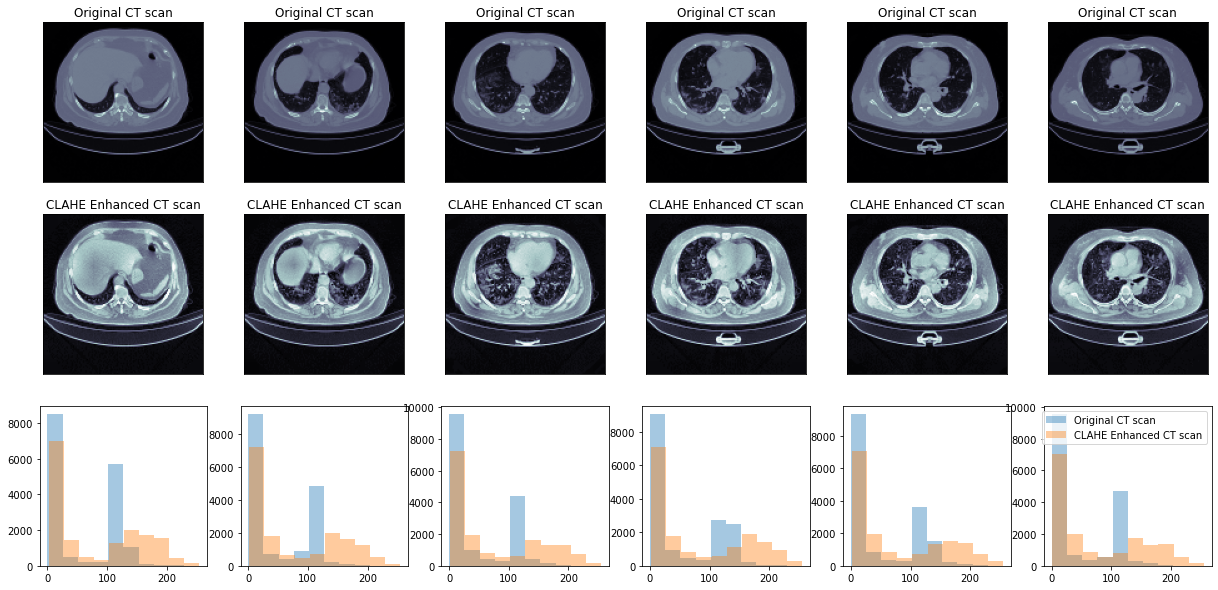

In [6]:
img_size = 128
clahe = cv2.createCLAHE(clipLimit=5.0)


cts = nib.load(metadata.loc[0, 'ct_scan'])
slices = cts.shape[2]
print('Number of slices: ', slices)
    
arr = cts.get_fdata()
arr = np.rot90(np.array(arr))
arr = arr[:,:,range(80,200,20)]
arr = np.reshape(np.rollaxis(arr, 2),(arr.shape[2],arr.shape[0],arr.shape[1], 1))

fig, axes = plt.subplots(3, 6, figsize=(21,10))    

for i in range(arr.shape[0]):
    img = cv2.resize(arr[i], dsize=(img_size, img_size), interpolation=cv2.INTER_AREA)
    xmax, xmin = img.max(), img.min()
    img = (img - xmin)/(xmax - xmin)
    clahe_img = clahe_enhancer(img, clahe, list(axes[:, i]))

#  Cropping the Region of interest(ROI)

In [7]:
def get_contours(img):
    img = np.uint8(img*255)
    
    kernel = np.ones((3,3),np.float32)/9
    img = cv2.filter2D(img, -1, kernel)
    
    ret, thresh = cv2.threshold(img, 50, 255, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(thresh, 2, 1)
    
    # filter contours that are too large or small
    size = get_size(img)
    contours = [cc for cc in contours if contourOK(cc, size)]
    return contours

def get_size(img):
    ih, iw = img.shape
    return iw * ih

def contourOK(cc, size):
    x, y, w, h = cv2.boundingRect(cc)
    if ((w < 50 and h > 150) or (w > 150 and h < 50)) : 
        return False # too narrow or wide is bad
    area = cv2.contourArea(cc)
    return area < (size * 0.5) and area > 200

def find_boundaries(img, contours):
    # margin is the minimum distance from the edges of the image, as a fraction
    ih, iw = img.shape
    minx = iw
    miny = ih
    maxx = 0
    maxy = 0

    for cc in contours:
        x, y, w, h = cv2.boundingRect(cc)
        if x < minx: minx = x
        if y < miny: miny = y
        if x + w > maxx: maxx = x + w
        if y + h > maxy: maxy = y + h

    return (minx, miny, maxx, maxy)

def crop_(img, boundaries):
    minx, miny, maxx, maxy = boundaries
    return img[miny:maxy, minx:maxx]

def crop_img(img, axes) :
    contours = get_contours(img)
    bounds = find_boundaries(img, contours)
    cropped_img = crop_(img, bounds)

    if len(axes) > 0 :
        axes[0].imshow(img, cmap='bone')
        axes[0].set_title("Original CT scan")
        axes[0].set_xticks([]); axes[0].set_yticks([])
        
        axes[1].imshow(cropped_img, cmap='bone')
        axes[1].set_title("Cropped CT scan")
        axes[1].set_xticks([]); axes[1].set_yticks([])
        
    return cropped_img, bounds

# **Displaying Original images , Enhanced image and cropped image **

Number of slices:  301


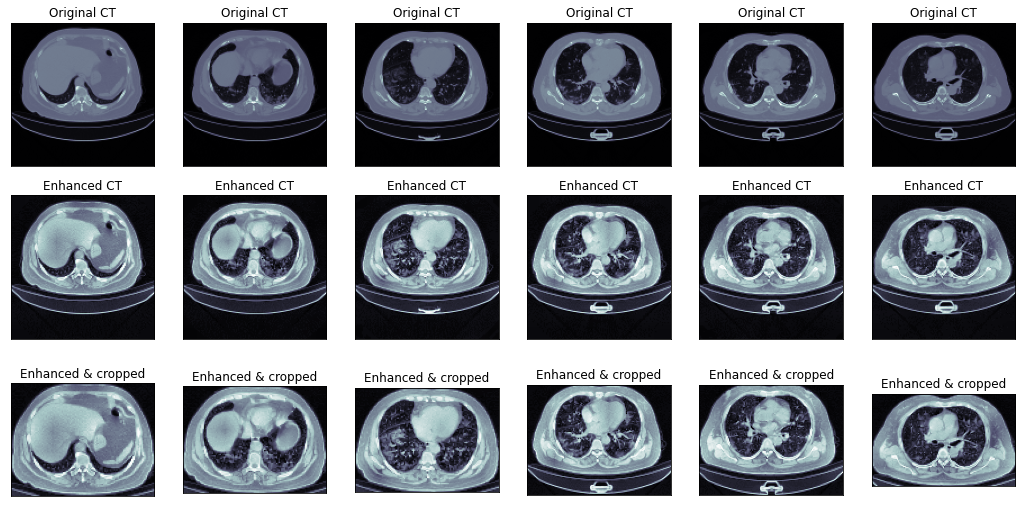

In [8]:
cts = nib.load(metadata.loc[0, 'ct_scan'])
slices = cts.shape[2]
print('Number of slices: ', slices)
    
arr = cts.get_fdata()
arr = np.rot90(np.array(arr))
arr = arr[:,:,range(80,200,20)]
arr = np.reshape(np.rollaxis(arr, 2),(arr.shape[2],arr.shape[0],arr.shape[1], 1))

fig, axes = plt.subplots(3, 6, figsize=(18,9))    

for i in range(arr.shape[0]):
    img = cv2.resize(arr[i], dsize=(img_size, img_size), interpolation=cv2.INTER_AREA)
    xmax, xmin = img.max(), img.min()
    img = (img - xmin)/(xmax - xmin)
    _, bounds = crop_img(img, [])
    axes[0,i].imshow(img, cmap='bone')
    axes[0,i].set_title('Original CT')
    axes[0,i].set_xticks([]); axes[0,i].set_yticks([])
    
    clahe_img = clahe_enhancer(img, clahe, [])
    axes[1,i].imshow(clahe_img, cmap='bone')
    axes[1,i].set_title('Enhanced CT')
    axes[1,i].set_xticks([]); axes[1,i].set_yticks([])
    
    cropped_img = crop_(clahe_img, bounds)
    axes[2,i].imshow(cropped_img, cmap='bone')
    axes[2,i].set_title('Enhanced & cropped')
    axes[2,i].set_xticks([]); axes[2,i].set_yticks([])

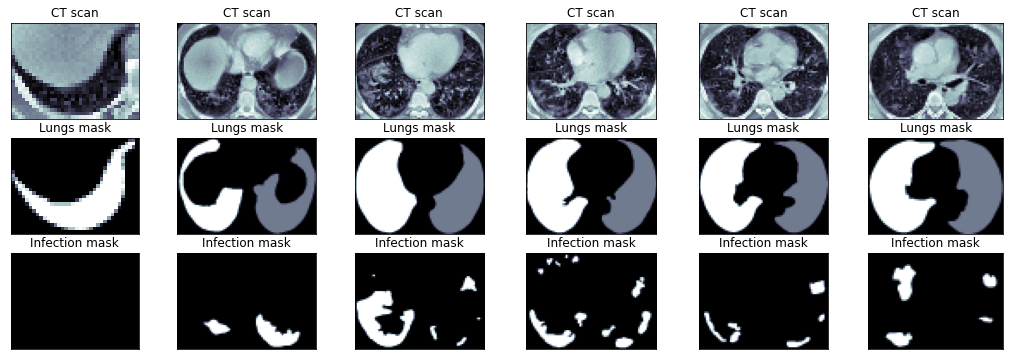

In [9]:
cts = nib.load(metadata.loc[0, 'ct_scan'])
lungs = nib.load(metadata.loc[0, 'lung_mask'])
infec = nib.load(metadata.loc[0, 'infection_mask'])
slices = cts.shape[2]
    
arr_cts = cts.get_fdata()
arr_lungs = lungs.get_fdata()
arr_infec = infec.get_fdata()

arr_cts = np.rot90(np.array(arr_cts))
arr_lungs = np.rot90(np.array(arr_lungs))
arr_infec = np.rot90(np.array(arr_infec))

arr_cts = arr_cts[:, :, range(80,200,20)]
arr_lungs = arr_lungs[:, :, range(80,200,20)]
arr_infec = arr_infec[:, :, range(80,200,20)]

arr_cts = np.reshape(np.rollaxis(arr_cts, 2), 
                     (arr_cts.shape[2],arr_cts.shape[0],arr_cts.shape[1], 1))
arr_lungs = np.reshape(np.rollaxis(arr_lungs, 2), 
                     (arr_lungs.shape[2],arr_lungs.shape[0],arr_lungs.shape[1], 1))
arr_infec = np.reshape(np.rollaxis(arr_infec, 2), 
                     (arr_infec.shape[2],arr_infec.shape[0],arr_infec.shape[1], 1))

fig, axes = plt.subplots(3, 6, figsize=(18,6))    

for i in range(arr_cts.shape[0]):
    img_ct = cv2.resize(arr_cts[i], dsize=(img_size, img_size), interpolation=cv2.INTER_AREA)
    img_lungs = cv2.resize(arr_lungs[i], dsize=(img_size, img_size), interpolation=cv2.INTER_AREA)
    img_infec = cv2.resize(arr_infec[i], dsize=(img_size, img_size), interpolation=cv2.INTER_AREA)
    
    xmax, xmin = img_lungs.max(), img_lungs.min()
    img_lungs = (img_lungs - xmin)/(xmax - xmin)
    cropped_lungs, bounds = crop_img(img_lungs, [])
    
    xmax, xmin = img_ct.max(), img_ct.min()
    img_ct = (img_ct - xmin)/(xmax - xmin)
    clahe_ct = clahe_enhancer(img_ct, clahe, [])
    cropped_ct = crop_(clahe_ct, bounds)
    cropped_infec = crop_(img_infec, bounds)
    
    axes[0,i].imshow(cropped_ct, cmap='bone')
    axes[0,i].set_title("CT scan")
    axes[0,i].set_xticks([]); axes[0,i].set_yticks([])
    
    axes[1,i].imshow(cropped_lungs, cmap='bone')
    axes[1,i].set_title("Lungs mask")
    axes[1,i].set_xticks([]); axes[1,i].set_yticks([])

    axes[2,i].imshow(cropped_infec, cmap='bone')
    axes[2,i].set_title("Infection mask")
    axes[2,i].set_xticks([]); axes[2,i].set_yticks([])

# **Ctscan Image with corresponding Lung mask and infection mask**

- - - - - - - - - - - - - -- - - - - - - - - - - - - - - - - - - - - - - - - - - -- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# Appending Enhanced data into new variables - > cts_all , lungs_all , infects_all

In [10]:
cts_all = []
lungs_all = []
infects_all = []
max_w, max_h = 0, 0 #max width and height

for fnum in tqdm(range(3)) : #range(metadata.shape[0])) :
    cts = nib.load(metadata.loc[fnum, 'ct_scan'])
    lungs = nib.load(metadata.loc[fnum, 'lung_mask'])
    infec = nib.load(metadata.loc[fnum, 'infection_mask'])
    
    slices = cts.shape[2]

    arr_cts = cts.get_fdata()
    arr_lungs = lungs.get_fdata()
    arr_infec = infec.get_fdata()

    arr_cts = np.rot90(np.array(arr_cts))
    arr_lungs = np.rot90(np.array(arr_lungs))
    arr_infec = np.rot90(np.array(arr_infec))

    arr_cts = arr_cts[:, :, round(slices*0.2):round(slices*0.8)]
    arr_lungs = arr_lungs[:, :, round(slices*0.2):round(slices*0.8)]
    arr_infec = arr_infec[:, :, round(slices*0.2):round(slices*0.8)]

    arr_cts = np.reshape(np.rollaxis(arr_cts, 2), 
                     (arr_cts.shape[2],arr_cts.shape[0],arr_cts.shape[1], 1))
    arr_lungs = np.reshape(np.rollaxis(arr_lungs, 2), 
                     (arr_lungs.shape[2],arr_lungs.shape[0],arr_lungs.shape[1], 1))
    arr_infec = np.reshape(np.rollaxis(arr_infec, 2), 
                     (arr_infec.shape[2],arr_infec.shape[0],arr_infec.shape[1], 1))
    
    
    
    for i in range(arr_cts.shape[0]):
        img_lungs = cv2.resize(arr_lungs[i], dsize=(img_size, img_size), 
                              interpolation=cv2.INTER_AREA)
        xmax, xmin = img_lungs.max(), img_lungs.min()
        img_lungs = (img_lungs - xmin)/(xmax - xmin)
        cropped_lungs, bounds = crop_img(img_lungs, [])
        lungs_all.append(cropped_lungs)
        
        h, w = cropped_img.shape
        max_h, max_w = max(max_h, h), max(max_w, w)

        img_ct = cv2.resize(arr_cts[i], dsize=(img_size, img_size), 
                           interpolation=cv2.INTER_AREA)
        xmax, xmin = img_ct.max(), img_ct.min()
        img_ct = (img_ct - xmin)/(xmax - xmin)
        clahe_ct = clahe_enhancer(img_ct, clahe, [])
        cropped_ct = crop_(clahe_ct, bounds)
        cts_all.append(cropped_ct)

        img_infec = cv2.resize(arr_infec[i], dsize=(img_size, img_size), 
                              interpolation=cv2.INTER_AREA)
        cropped_infec = crop_(img_infec, bounds)
        infects_all.append(cropped_infec)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning:

invalid value encountered in true_divide



In [11]:
print(len(cts_all))

227


##  Removing incomplete and faulty images

In [12]:
#Reshape each slice and delete faulty images

pix_size = 256

del_lst = []
for i in tqdm(range(len(cts_all))) :
    try :
        cts_all[i] = cv2.resize(cts_all[i], dsize=(pix_size, pix_size), interpolation=cv2.INTER_AREA)
        cts_all[i] = np.reshape(cts_all[i], (pix_size, pix_size, 1))

        lungs_all[i] = cv2.resize(lungs_all[i], dsize=(pix_size, pix_size), interpolation=cv2.INTER_AREA)
        lungs_all[i] = np.reshape(lungs_all[i], (pix_size, pix_size, 1))

        infects_all[i] = cv2.resize(infects_all[i], dsize=(pix_size, pix_size), interpolation=cv2.INTER_AREA)
        infects_all[i] = np.reshape(infects_all[i], (pix_size, pix_size, 1))
    except :
        del_lst.append(i)
            
    
for idx in del_lst[::-1] :
    del cts_all[idx]
    del lungs_all[idx]
    del infects_all[idx]

In [13]:
print(len(cts_all))

210


In [14]:
def check_empty(img):
    # Count white pixels
    sought = [1,1,1]
    white  = np.count_nonzero(img==sought)
    
    if white == 0:
        return(True)

# Deleting empty masks

In [15]:


del_lst = []
for i in tqdm(range(len(infects_all))) :
    if check_empty(infects_all[i]):
        del_lst.append(i)
            
    
for idx in del_lst[::-1] :
    del cts_all[idx]
    del lungs_all[idx]
    del infects_all[idx]

In [16]:
print(len(cts_all)) # len of correct slices

153


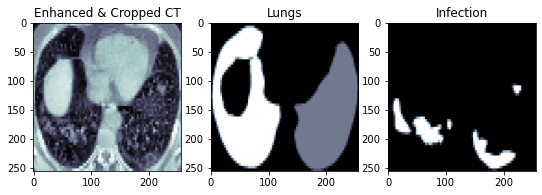

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(9,3))

axes[0].imshow(cts_all[25][:, :, 0],cmap = 'bone')
axes[0].set_title("Enhanced & Cropped CT")

axes[1].imshow(lungs_all[25][:, :, 0], cmap='bone')
axes[1].set_title("Lungs")

axes[2].imshow(infects_all[25][:, :, 0], cmap='bone')
axes[2].set_title("Infection");


#                          Demo of final image after preprocessing 

------------------------------------------------------------------------------------------------

##  **Defining Covid19 CT Dataset** 

In [18]:
class Covid19_CT_Dataset(torch.utils.data.Dataset):
    
    def __init__(self, cts, masks, transforms=None):
        self.transforms = transforms
        self.cts = cts
        self.masks = masks
        self.len = len(cts)
        
    def __getitem__(self,index):
        

        image = self.cts[index]
        target_mask = self.masks[index]
           
        
        if self.transforms is not None:
            augment = self.transforms(image=image,mask=target_mask)
            image = augment['image']
            target_mask = augment['mask']


        target_mask = ToTensor()(image=target_mask)['image']
        
        image = ToTensor()(image=image)['image']
        
        result = {
            
            'image': image,
            'mask': target_mask
                 
        }
        
        return result
    
    
    def __len__(self):
        return self.len

## **Simple augmentations for train subset**

In [19]:
transforms = {
    'base': Compose([
                    HorizontalFlip(p=0.5),
                    VerticalFlip(p=0.2),
                    ]),    
}

In [20]:
dataset = Covid19_CT_Dataset(cts_all,lungs_all)

Text(0.5, 1.0, 'Ground Truth')

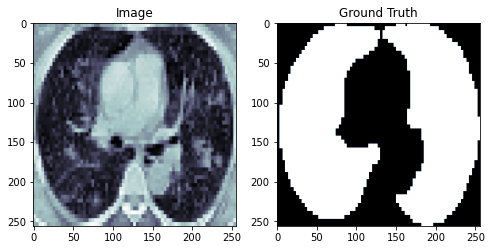

In [21]:
img_id = 100

fig, axes = plt.subplots(1, 2, figsize=(8,8)) 

axes[0].imshow(dataset[img_id]["image"].squeeze() , cmap = 'bone')
axes[0].set_title("Image")


axes[1].imshow(dataset[img_id]["mask"].squeeze() > 0 , cmap = 'bone')
axes[1].set_title("Ground Truth")
# Ground truth masks are often created by human annotators who carefully outline the desired objects or regions in the image.

## **U-Net baseline**

In [22]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
#         if bilinear:
#             self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
#             self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
#         else:
        self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)
        
#         self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
#         self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
    
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        
    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    """ Full assembly of the parts to form the complete network """
    def __init__(self, n_channels = 1, n_classes = 1):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)

        return logits

## **Defining subsets for Task 1 and Task 2** 

In [23]:
csv_file = r'../input/covid19-ct-scans/metadata.csv'
df = pd.read_csv(csv_file)
train_val_thresh = int(len(cts_all)*0.8)

cts_path = df['ct_scan'].tolist()
lungs_path = df['lung_mask'].tolist()
infects_path = df['infection_mask'].tolist()

train_cts = cts_all[:train_val_thresh]
train_lungs = lungs_all[:train_val_thresh]
train_infects = infects_all[:train_val_thresh]

val_cts = cts_all[train_val_thresh:]
val_lungs = lungs_all[train_val_thresh:]
val_infects = infects_all[train_val_thresh:]

In [24]:
lungs_train = Covid19_CT_Dataset(train_cts, train_lungs, transforms = transforms['base']) # for Task 1
lungs_val = Covid19_CT_Dataset(val_cts, val_lungs)

infects_train = Covid19_CT_Dataset(train_cts, train_infects, transforms = transforms['base']) # for Task 2
infects_val = Covid19_CT_Dataset(val_cts, val_infects)

In [25]:
lungs_train_loader = torch.utils.data.DataLoader(lungs_train, batch_size=32, shuffle=True, num_workers=2)
lungs_val_loader = torch.utils.data.DataLoader(lungs_val, batch_size=32, shuffle=False, num_workers=2)

infects_train_loader = torch.utils.data.DataLoader(infects_train, batch_size=32, shuffle=True, num_workers=2)
infects_val_loader = torch.utils.data.DataLoader(infects_val, batch_size=32, shuffle=False, num_workers=2)

In [26]:
def predict(model, data, threshold, threshold_value):
    
    x = data["image"].unsqueeze(0).to("cuda") # Add batch dimension

    output = model(x) # Forward pass

    probs = torch.sigmoid(output)

    full_mask = probs.squeeze().cpu().detach().numpy()
    
    if threshold:
        res = full_mask > threshold_value
    else:
        res = full_mask

    return res

def visualize_mask(model, dataset, threshold = True, threshold_value = 0.5):
    
    fig, axes = plt.subplots(3, 3, figsize=(14,14)) 

    for i in range(3):

        num = int(np.random.uniform(0, len(dataset)))

        axes[i,0].imshow(dataset[num]["image"].numpy().squeeze(), cmap = 'bone')
        axes[i,0].set_title("Image")

        axes[i,1].imshow(dataset[num]["mask"].numpy().squeeze() > 0, cmap = 'bone')
        axes[i,1].set_title("Ground Truth")

        axes[i,2].imshow(predict(model, dataset[num], threshold, threshold_value), cmap = 'bone')
        axes[i,2].set_title("Prediction (thresholded)")

## **Defining runner for training**

In [27]:
ALPHA = 1
BETA = 1

class TverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(TverskyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=ALPHA, beta=BETA):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()    
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()
       
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        
        return 1 - Tversky

In [28]:
criterion = {
    "tversky":TverskyLoss()
}

callbacks = [
    dl.CriterionCallback(
        input_key="mask", prefix="loss_tversky", criterion_key="tversky"
    ),
    dl.MetricAggregationCallback(
        prefix="loss",
        mode="weighted_sum",
        metrics={"loss_tversky": 1.0},
    ),
    dl.DiceCallback(input_key="mask"),
    dl.IouCallback(input_key="mask"),
    dl.callbacks.WandbLogger(
            project="lungs_infs_segmentation"
        )
]


# **Lungs Segmentations**
---

In [29]:
lungs_model = UNet().to(device)

In [30]:
lungs_runner = SupervisedRunner(input_key="image", input_target_key="mask", device=device)

optimizer = torch.optim.Adam(lungs_model.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = 10, eta_min = 1e-6)

lungs_loaders = {
    "train": lungs_train_loader,
    "valid": lungs_val_loader,
}


In [31]:
lungs_runner.train(
    model = lungs_model,
    criterion = criterion,
    optimizer = optimizer,
    scheduler = scheduler,
    loaders = lungs_loaders,
    callbacks = callbacks,
    num_epochs = 100,
    main_metric = "dice", 
    minimize_metric = False,
    verbose = True,
    
)

wandb: WARNING Path None/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path None/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path None/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path None/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path None/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path None/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path None/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path None/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path None/wandb/ wasn't writable, using system temp directory


wandb: WARNING Path None/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path None/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path None/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path None/wandb/ wasn't writable, using system temp directory
wandb: Wandb version 0.15.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: WARNING Path None/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path None/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path None/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path None/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path None/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path None/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path None/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path None/wandb/ wasn't writable,

1/100 * Epoch (train):   0% 0/4 [00:00<?, ?it/s]

wandb: WARNING Path None/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path None/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path None/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path None/wandb/ wasn't writable, using system temp directory
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1569: UserWarning:

nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.



1/100 * Epoch (train): 100% 4/4 [00:04<00:00,  1.10s/it, dice=0.693, iou=0.530, loss=0.470, loss_tversky=0.470]
1/100 * Epoch (valid): 100% 1/1 [00:00<00:00,  2.38it/s, dice=0.467, iou=0.304, loss=0.696, loss_tversky=0.696]
[2023-07-14 13:15:39,242] 
1/100 * Epoch 1 (_base): lr=0.0010 | momentum=0.9000
1/100 * Epoch 1 (train): dice=0.5678 | iou=0.4065 | loss=0.5935 | loss_tversky=0.5935
1/100 * Epoch 1 (valid): dice=0.4668 | iou=0.3045 | loss=0.6955 | loss_tversky=0.6955
2/100 * Epoch (train):   0% 0/4 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:942: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



2/100 * Epoch (train): 100% 4/4 [00:03<00:00,  1.13it/s, dice=0.735, iou=0.581, loss=0.419, loss_tversky=0.419]
2/100 * Epoch (valid): 100% 1/1 [00:00<00:00,  2.41it/s, dice=0.518, iou=0.350, loss=0.650, loss_tversky=0.650]
[2023-07-14 13:15:43,228] 
2/100 * Epoch 2 (_base): lr=0.0009 | momentum=0.9000
2/100 * Epoch 2 (train): dice=0.7212 | iou=0.5641 | loss=0.4359 | loss_tversky=0.4359
2/100 * Epoch 2 (valid): dice=0.5181 | iou=0.3496 | loss=0.6504 | loss_tversky=0.6504
3/100 * Epoch (train): 100% 4/4 [00:03<00:00,  1.13it/s, dice=0.752, iou=0.602, loss=0.398, loss_tversky=0.398]
3/100 * Epoch (valid): 100% 1/1 [00:00<00:00,  2.33it/s, dice=0.596, iou=0.425, loss=0.575, loss_tversky=0.575]
[2023-07-14 13:15:47,233] 
3/100 * Epoch 3 (_base): lr=0.0008 | momentum=0.9000
3/100 * Epoch 3 (train): dice=0.7437 | iou=0.5919 | loss=0.4081 | loss_tversky=0.4081
3/100 * Epoch 3 (valid): dice=0.5962 | iou=0.4247 | loss=0.5753 | loss_tversky=0.5753
4/100 * Epoch (train): 100% 4/4 [00:03<00:00,  1

wandb: WARNING Path None/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path None/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path None/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path None/wandb/ wasn't writable, using system temp directory


## **Checking ( For Training data) model inference**

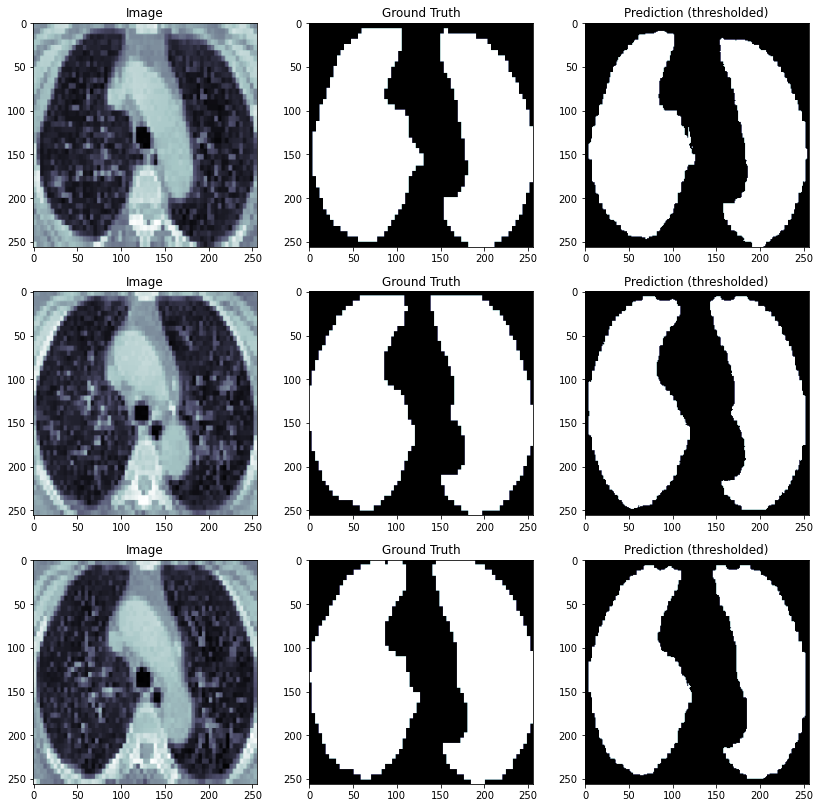

In [32]:
visualize_mask(lungs_model, lungs_val)

# **Infection Segmentation**
---

In [33]:
torch.cuda.empty_cache()

In [34]:
infects_model = UNet().to(device)

In [35]:
infects_runner = SupervisedRunner(input_key="image", input_target_key="mask", device=device)

optimizer = torch.optim.Adam(infects_model.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = 10, eta_min = 1e-6)

infects_loaders = {
    "train": infects_train_loader,
    "valid": infects_val_loader,
}

In [36]:
infects_runner.train(
    model = infects_model,
    criterion = criterion,
    optimizer = optimizer,
    scheduler = scheduler,
    loaders = infects_loaders,
    callbacks = callbacks,
    num_epochs = 100,
    main_metric = "dice", 
    minimize_metric = False,
    verbose = True,
)

wandb: WARNING Path None/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path None/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path None/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path None/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path None/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path None/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path None/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path None/wandb/ wasn't writable, using system temp directory


wandb: WARNING Path None/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path None/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path None/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path None/wandb/ wasn't writable, using system temp directory
wandb: Wandb version 0.15.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: WARNING Path None/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path None/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path None/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path None/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path None/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path None/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path None/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path None/wandb/ wasn't writable,

1/100 * Epoch (train):   0% 0/4 [00:00<?, ?it/s]

wandb: WARNING Path None/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path None/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path None/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path None/wandb/ wasn't writable, using system temp directory


1/100 * Epoch (train): 100% 4/4 [00:03<00:00,  1.07it/s, dice=0.262, iou=0.151, loss=0.849, loss_tversky=0.849]
1/100 * Epoch (valid): 100% 1/1 [00:00<00:00,  2.25it/s, dice=0.035, iou=0.018, loss=0.982, loss_tversky=0.982]
[2023-07-14 13:22:26,904] 
1/100 * Epoch 1 (_base): lr=0.0010 | momentum=0.9000
1/100 * Epoch 1 (train): dice=0.2050 | iou=0.1149 | loss=0.8851 | loss_tversky=0.8851
1/100 * Epoch 1 (valid): dice=0.0351 | iou=0.0179 | loss=0.9821 | loss_tversky=0.9821
2/100 * Epoch (train): 100% 4/4 [00:03<00:00,  1.11it/s, dice=0.316, iou=0.188, loss=0.812, loss_tversky=0.812]
2/100 * Epoch (valid): 100% 1/1 [00:00<00:00,  2.30it/s, dice=0.036, iou=0.018, loss=0.982, loss_tversky=0.982]
[2023-07-14 13:22:30,960] 
2/100 * Epoch 2 (_base): lr=0.0009 | momentum=0.9000
2/100 * Epoch 2 (train): dice=0.2937 | iou=0.1722 | loss=0.8278 | loss_tversky=0.8278
2/100 * Epoch 2 (valid): dice=0.0356 | iou=0.0181 | loss=0.9819 | loss_tversky=0.9819
3/100 * Epoch (train): 100% 4/4 [00:03<00:00,  1

wandb: WARNING Path None/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path None/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path None/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path None/wandb/ wasn't writable, using system temp directory


## **Checking model inference For Infection Segmetation (Training data)**

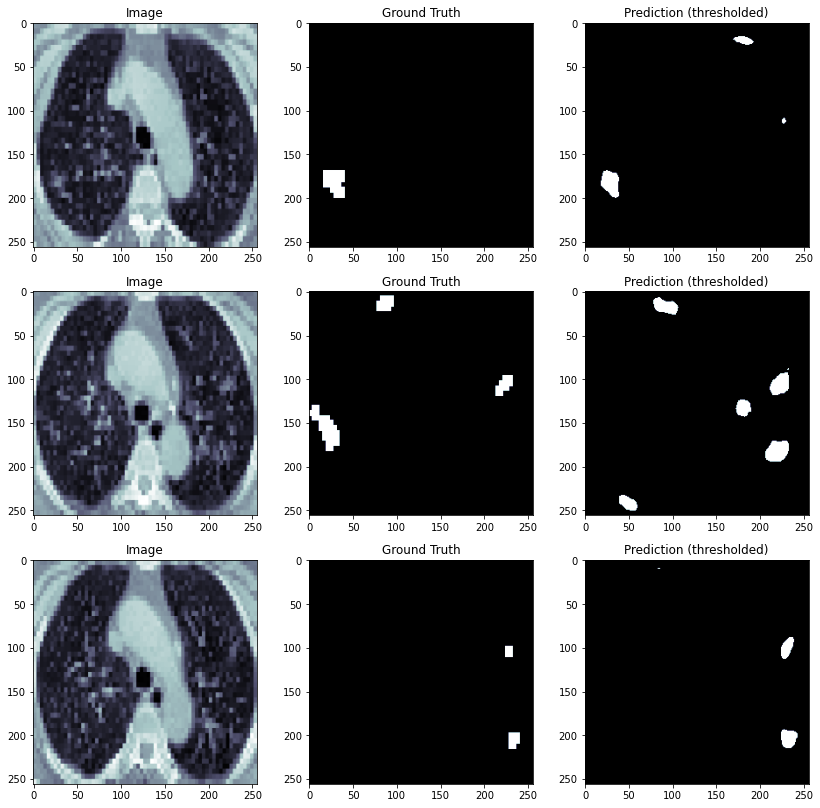

In [37]:
visualize_mask(infects_model, infects_val, threshold = True, threshold_value = 0.9)

=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-

# Save Model to a file named lungs_model

In [38]:
import pickle
# Save the model to a file
filename = 'lungs_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(lungs_model, file)

/opt/conda/lib/python3.7/site-packages/torch/storage.py:34: FutureWarning:

pickle support for Storage will be removed in 1.5. Use `torch.save` instead



# Loading Model for further Testing

In [39]:
import pickle
model = pickle.load(open('/kaggle/working/lungs_model.pkl','rb'))

In [40]:
import pickle
# Save the model to a file
filename = 'infects_model1.pkl'
with open(filename, 'wb') as file:
    pickle.dump(infects_model, file)

In [41]:
infects_model = UNet().to(device)
torch.save(infects_model.state_dict(), '/kaggle/working/infects_model.pkl')

In [42]:
# Assuming you have already defined and instantiated your lungs_model
lungs_model = UNet().to(device)

# Print the model summary
print(lungs_model)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

In [43]:
import os

# **Testing Model On CSV file**

In [44]:
def predict(model, data, threshold, threshold_value):
    
    x = data["image"].unsqueeze(0).to("cuda") # Add batch dimension

    output = model(x) # Forward pass

    probs = torch.sigmoid(output)

    full_mask = probs.squeeze().cpu().detach().numpy()
    
    if threshold:
        res = full_mask > threshold_value
    else:
        res = full_mask

    return res

def visualize_mask(model, dataset, threshold = True, threshold_value = 0.5):
    
    fig, axes = plt.subplots(3, 3, figsize=(14,14)) 

    for i in range(3):

        num = int(np.random.uniform(0, len(dataset)))

        axes[i,0].imshow(dataset[num]["image"].numpy().squeeze(), cmap = 'bone')
        axes[i,0].set_title("Image")

        axes[i,1].imshow(dataset[num]["mask"].numpy().squeeze() > 0, cmap = 'bone')
        axes[i,1].set_title("Ground Truth")

        axes[i,2].imshow(predict(model, dataset[num], threshold, threshold_value), cmap = 'bone')
        axes[i,2].set_title("Prediction (thresholded)")


In [45]:
def caller_func(lungs_model,infects_model,path):
    csv_file = path
    df = pd.read_csv(csv_file)
    train_val_thresh = int(len(cts_all)*0.8)

    cts_path = df['ct_scan'].tolist()
    lungs_path = df['lung_mask'].tolist()
    infects_path = df['infection_mask'].tolist()

    train_cts = cts_all[:train_val_thresh]
    train_lungs = lungs_all[:train_val_thresh]
    train_infects = infects_all[:train_val_thresh]

    val_cts = cts_all[train_val_thresh:]
    val_lungs = lungs_all[train_val_thresh:]
    val_infects = infects_all[train_val_thresh:]
    lungs_train = Covid19_CT_Dataset(train_cts, train_lungs, transforms = transforms['base']) # for Task 1
    lungs_val = Covid19_CT_Dataset(val_cts, val_lungs)

    infects_train = Covid19_CT_Dataset(train_cts, train_infects, transforms = transforms['base']) # for Task 2
    infects_val = Covid19_CT_Dataset(val_cts, val_infects)
    lungs_train_loader = torch.utils.data.DataLoader(lungs_train, batch_size=32, shuffle=True, num_workers=2)
    lungs_val_loader = torch.utils.data.DataLoader(lungs_val, batch_size=32, shuffle=False, num_workers=2)

    infects_train_loader = torch.utils.data.DataLoader(infects_train, batch_size=32, shuffle=True, num_workers=2)
    infects_val_loader = torch.utils.data.DataLoader(infects_val, batch_size=32, shuffle=False, num_workers=2)
    
    visualize_mask(lungs_model, lungs_val)
    visualize_mask(infects_model, infects_val)
    
    

In [46]:
#Evaluate the pickle model
import pickle
lungs_model = pickle.load(open('/kaggle/working/lungs_model.pkl','rb'))

In [47]:
#Evaluate the pickle model
import pickle
infects_model = pickle.load(open('/kaggle/working/infects_model1.pkl','rb'))

----------------------------------------------------------------------------------------------------------------
# Test Case 1

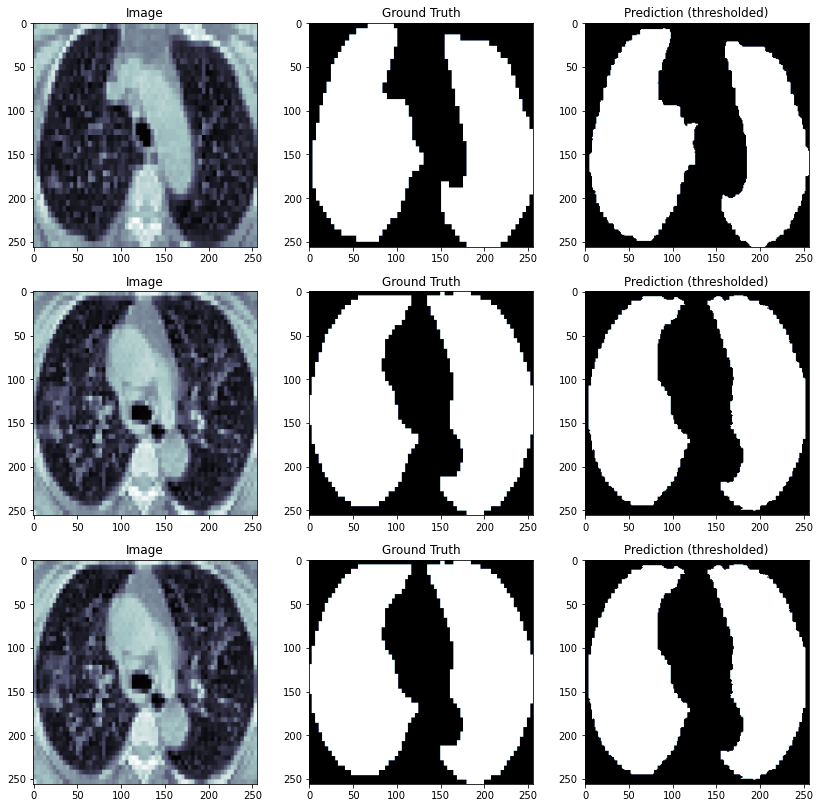

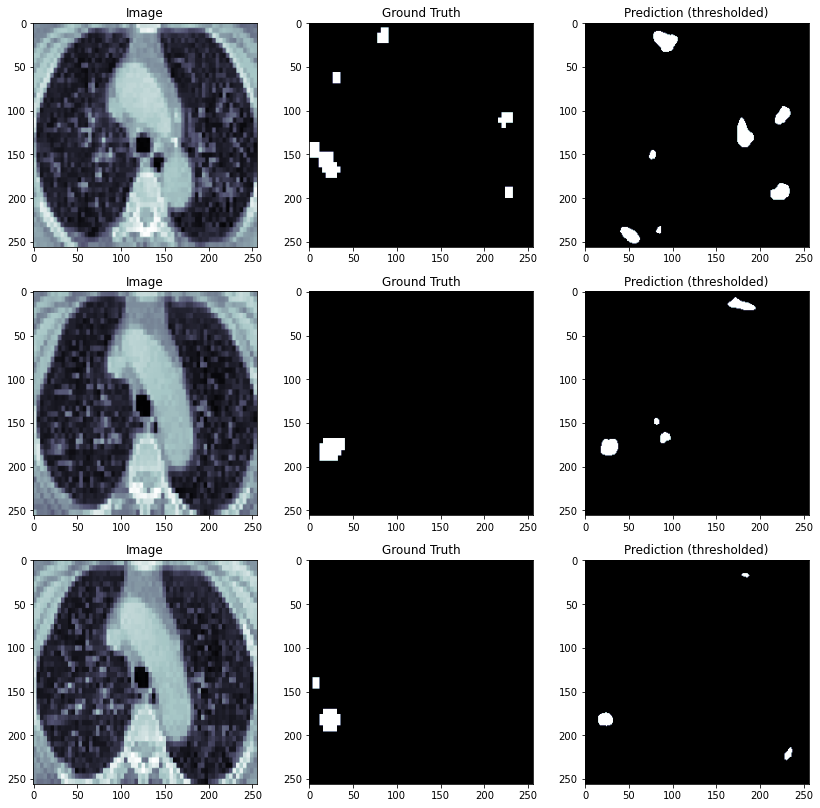

In [59]:
caller_func(lungs_model,infects_model,'/kaggle/input/test-cases/TestCase1/metadata.csv')

-----------------------------------------------------------------------------------------------------------
# Test Case 2

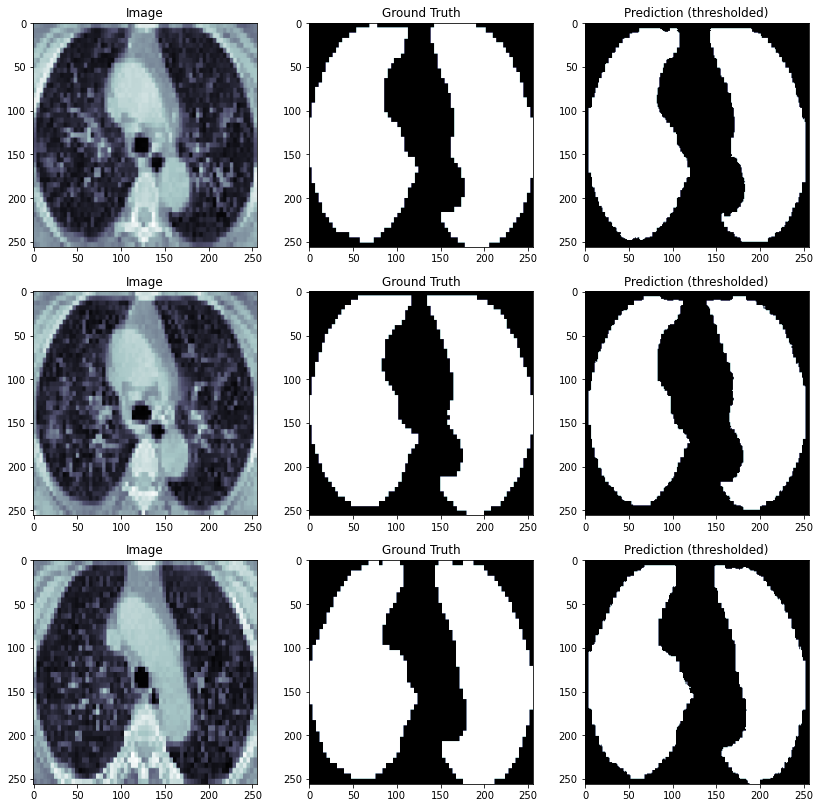

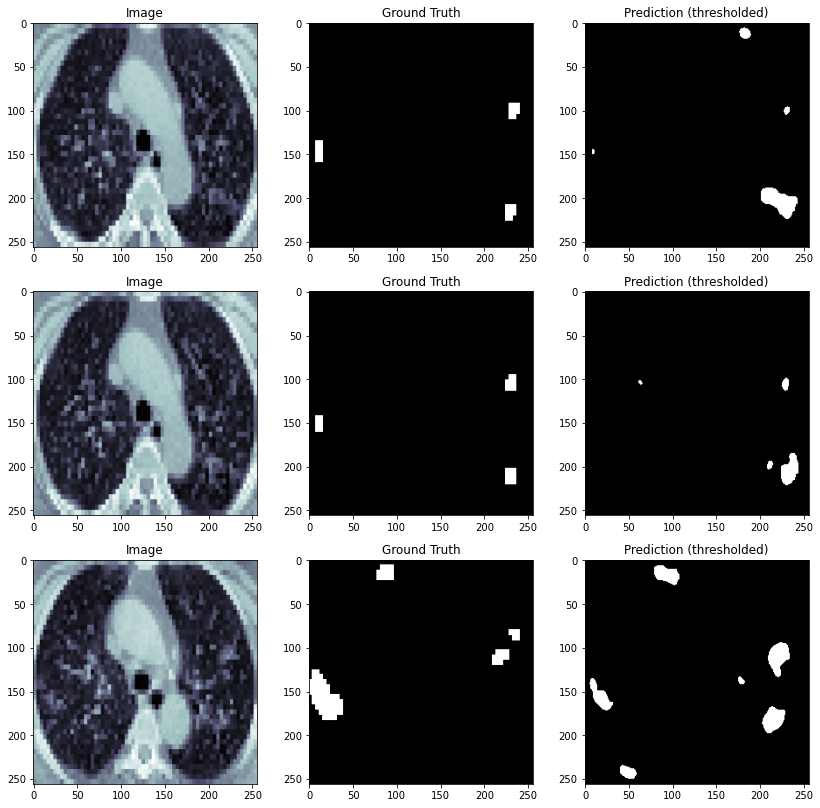

In [60]:
caller_func(lungs_model,infects_model,'/kaggle/input/test-cases/TestCase2/metadata.csv')


# **TO RUN During the DEMO**

# Adding External Test cases For Testing

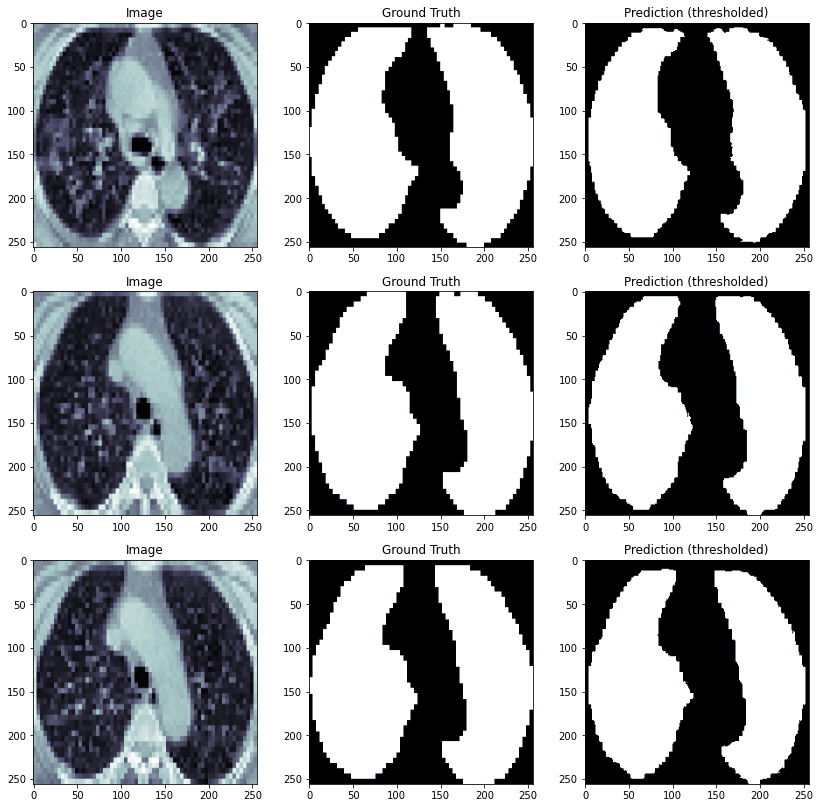

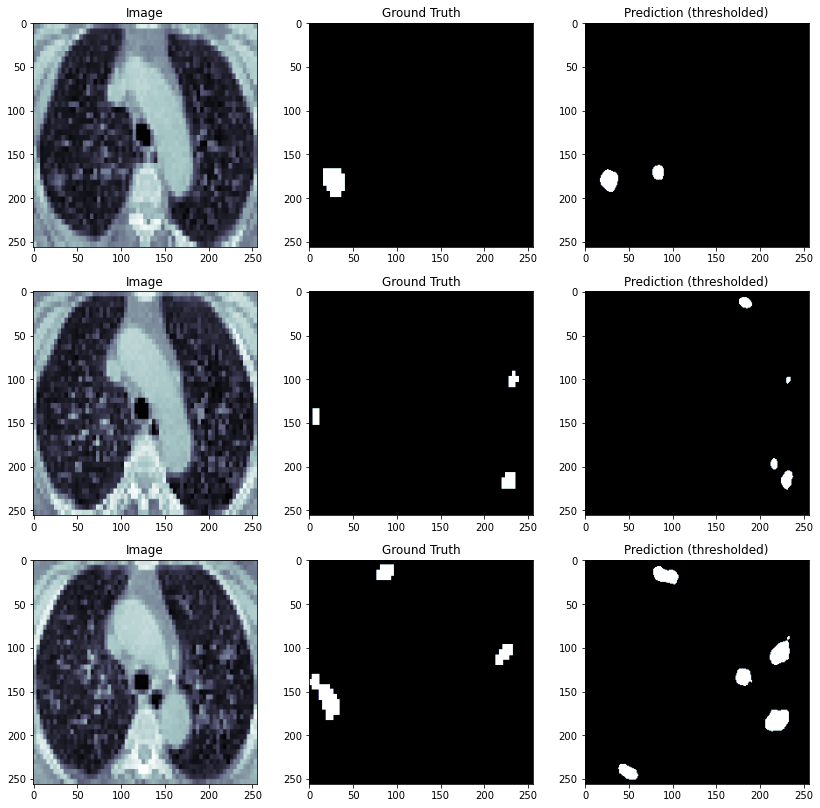

In [61]:
caller_func(lungs_model,infects_model,'/kaggle/input/test-case/TestCase/metadata.csv')

In [ ]:
THANKYOU 